In [1]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [2]:
import yaml
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from collections import defaultdict, namedtuple
from tqdm import tqdm

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from vae_experiment import VAEExperiment
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
# import (correlated)dsprites

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [5]:
curr_dev = torch.device("cuda:1")
dset_name = 'dsprites_correlated'
dset_dir = '../datasets'
batch_size = 144
seed = 123

ModelParams = namedtuple('ModelParams', ["z_dim", "l_dim", "num_labels" , "in_channels", 
                                        "image_size", "batch_size", "w_recon", "w_kld", 
                                         "controlled_capacity_increase", "max_c", "iterations_c",
                                        "w_tc", "w_infovae", "w_dipvae", "lambda_od", "lambda_d_factor",
                                        "encoder", "decoder", "loss_terms"])


experiment_config = dict(
        in_channels=1,
        image_size=64,
        LR=1e-4,
        weight_decay=0.0,       
        dataset=dset_name,
        datapath=dset_dir,
        droplast=True,        
        batch_size=batch_size,
        num_workers=8,
        pin_memory=True,
        seed=seed,
        evaluation_metrics=None,
        visdom_on=False,
        save_dir=None
)

def load_vae_model(algo_name, checkpoint_path, curr_dev, 
                   model_params, exp_params):
    
    import models
    
    vae_model_class = getattr(models, algo_name)
    vae_model = vae_model_class(model_params)
        
    vae_experiment = VAEExperiment.load_from_checkpoint(
        checkpoint_path,
        map_location=curr_dev,
        vae_model=vae_model, 
        params=exp_params)

    vae_experiment = vae_experiment.to(curr_dev)

    return vae_experiment

def get_latent_activations(dataset, vae_model, batch_size = 32, batches = None):
   
    loader = DataLoader(dataset, batch_size=batch_size, shuffle = True, drop_last=True)
    latent_act_dict = defaultdict(list)
    batches_processed = 0
    for x_batch, label_batch in tqdm(loader):
        
        if batches is not None and batches_processed >= batches:
            break
        
        # First we encode this batch
        x_batch = x_batch.to(curr_dev)
        #print(x_batch.shape)
        mu_batch, log_var_batch = vae_model.model.encode(x_batch)

        # Then, we get \mu and \sigma for this batch
        mu_batch = mu_batch.detach().cpu().numpy()
        log_var_batch = log_var_batch.detach().cpu().numpy()

        # and labels
        label_batch = label_batch.cpu().numpy()
        
        # using labels, we place all \mu's belonging to same class together
        for b in range(batch_size):

            mu_of_this_x = mu_batch[b]
            
            # for reach dimension
            for m, m_dim in enumerate(mu_of_this_x): 
                
                latent_act_dict[m].append(m_dim.item())
                
        batches_processed += 1
    
    return latent_act_dict

def plot_latent_dist(activations, label="Factor X"):

    fig, axes = plt.subplots(1)
    axes.hist(activations, label=label, align='mid')
    axes.legend(prop={'size': 10},loc='upper left')

# $\beta$-VAE on dsprites with $\beta$-VAE metric

# $\beta$-VAE on dsprites_correlated with $\beta$-VAE metric

In [ ]:
beta = 1.0
z_dim = 6
bvae_model_params = ModelParams(
    z_dim, 6, 0, 1, 64, batch_size, 1.0, beta,
    False, 0, 0,
    0, 0, 0, 0, 0,
    ['SimpleGaussianConv64'],['SimpleConv64'], None
)

checkpoint_path="../pl-dt-test/dsprites_uncorrelated_beta1_vae/version_0/checkpoints/epoch=29-step=115199.ckpt",

model_for_correlated_dsprites = load_vae_model(
    algo_name='BetaVAE', 
    checkpoint_path=checkpoint_path, 
    curr_dev=curr_dev,
    model_params=bvae_model_params,
    exp_params=experiment_config
)


correlated_dsprites_dataset = DSpritesDataset(root="../datasets/dsprites/", 
                                              split="train", correlated=True, transforms=transforms.ToTensor())

activations_for_correlated_dsprites = get_latent_activations(correlated_dsprites_dataset, 
                                                             model_for_correlated_dsprites,
                                                            batch_size=256,
                                                            batches=None)

In [ ]:
checkpoint_path = "../pl-dt-test/dsprites_noncorrelated_beta1_vae/version_0/checkpoints/epoch=29-step=115199.ckpt"

model_for_dsprites = load_vae_model(
    algo_name='BetaVAE', 
    checkpoint_path=checkpoint_path, 
    curr_dev=curr_dev,
    model_params=bvae_model_params,
    exp_params=experiment_config
)


dsprites_dataset = DSpritesDataset(root="../datasets/dsprites/", 
                                              split="train", correlated=False, transforms=transforms.ToTensor())

activations_for_dsprites = get_latent_activations(dsprites_dataset, 
                                                             model_for_dsprites,
                                                            batch_size=256,
                                                            batches=None)


In [ ]:
activations_for_dsprites.keys()

In [ ]:
plot_latent_dist(activations_for_correlated_dsprites[0], label="Factor 0")

In [ ]:
plot_latent_dist(activations_for_correlated_dsprites[1], label="Factor 1")

In [ ]:
activations_for_dsprites = get_latent_activations(dsprites_dataset, 
                                                             model_for_correlated_dsprites,
                                                            batch_size=256,
                                                            batches=None)

In [6]:
beta = 1.0
z_dim = 2
bvae_model_params = ModelParams(
    z_dim, 6, 0, 1, 64, batch_size, 1.0, beta,
    False, 0, 0,
    0, 0, 0, 0, 0,
    ['SimpleGaussianConv64'],['SimpleConv64'], None
)

# checkpoint_path="../pl-dt-test/dsprites_correlated_beta1_vae/version_5/checkpoints/epoch=30-step=119039.ckpt",
checkpoint_path="../pl-dt-test/3shapesnoisy_beta1/version_0/checkpoints/epoch=99-step=13999.ckpt"

model = load_vae_model(
    algo_name='BetaVAE', 
    checkpoint_path=checkpoint_path, 
    curr_dev=curr_dev,
    model_params=bvae_model_params,
    exp_params=experiment_config
)

threeshapes_dataset = ThreeShapesDataset(root="../datasets/threeshapesnoisy/", 
                                              split="train", transforms=transforms.ToTensor())


100%|██████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.47it/s]


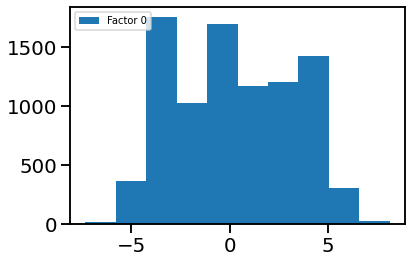

In [7]:

activations_for_threeshapes_dataset = get_latent_activations(threeshapes_dataset, 
                                                             model,
                                                            batch_size=1000,
                                                            batches=None)

plot_latent_dist(activations_for_threeshapes_dataset[0], label="Factor 0")

In [ ]:
checkpoint_path="../pl-dt-test/threeshapes_beta1_vae/version_0/checkpoints/epoch=99-step=5199.ckpt"

model_ = load_vae_model(
    algo_name='BetaVAE', 
    checkpoint_path=checkpoint_path, 
    curr_dev=curr_dev,
    model_params=bvae_model_params,
    exp_params=experiment_config
)

threeshapes_dataset = ThreeShapesDataset(root="../datasets/threeshapes/", 
                                              split="train", transforms=transforms.ToTensor())
activations_for_threeshapes_dataset = get_latent_activations(threeshapes_dataset, 
                                                             model_,
                                                            batch_size=9000,
                                                            batches=None)

plot_latent_dist(activations_for_threeshapes_dataset[0], label="Factor 0")

In [ ]:
activations_for_threeshapes_dataset.keys()